# Stock Price Forecasting with LSTMs

In this tutorial we are going to show how a simple LSTM can predict stock prices in the short term. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
import tensorflow as tf
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/Users/miguel/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


OS:  darwin
Python:  3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 18:11:28) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Keras:  2.1.5
Tensorflow:  1.5.0
Numpy:  1.14.1
Number of CPU processors:  8


### Data

The data we are going to use is Microsoft stock prices from 2012 to 2017. The data can be accessed directly in [Yahoo finance](https://finance.yahoo.com/quote/MSFT/history?p=MSFT).

In [2]:
DATA = os.path.join('data', 'MSFT_2012_2017.csv')
EPOCHS = 5
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
UNITS = 25

In [3]:
df = pd.read_csv(DATA)
df = df.drop(['Adj Close', 'Volume'], axis=1)
print(df.shape)
df.head()

(1509, 5)


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


To simplify the problem, we are going to take as input the average of the Open, High, Low and Close values.

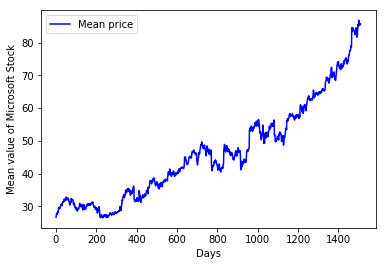

In [4]:
mean_price = df.mean(axis = 1)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')

The next step is to scale the dataset, this generally helps the prediction to be more accourate.

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

Once, the data has been scaled, we can create the train and test sets.

In [6]:
train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [7]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)

### LSTM

Now we are going to test different RNN structures.

In [8]:
def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(units, input_shape=(1, time_ahead)))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(units), input_shape=(1, time_ahead)))
    elif model_name == 'GRU':
        model.add(GRU(units, input_shape=(1, time_ahead)))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

Let's train the model. For optimization, we use ADAM algorithm. In time series, adaptative optimization methods tend to get better results than traditional stochastic gradient descent methods. You can play with the different [optimizers](https://keras.io/optimizers/) available in Keras.

In [9]:
model = create_symbol(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

In [10]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/5
 - 3s - loss: 0.0297
Epoch 2/5
 - 2s - loss: 4.4619e-04
Epoch 3/5
 - 2s - loss: 3.8161e-04
Epoch 4/5
 - 2s - loss: 3.7309e-04
Epoch 5/5
 - 2s - loss: 3.6114e-04


Once the model is trained, we can predict on the test set and obtain the RMSE value.

In [11]:
y_test_inv = scaler.inverse_transform([y_test])
mean_price_inv = scaler.inverse_transform(mean_price)

In [12]:
pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

Test RMSE: 3.65


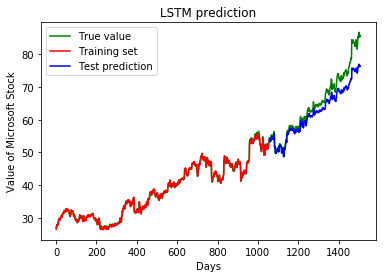

In [13]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='LSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       color=['g','r','b'], legend=['True value','Training set','Test prediction'])

### BiLSTM
Now we can try with a Bi-directional LSTM (BiLSTM).

In [14]:
model = create_symbol(model_name='BiLSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

In [15]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/5
 - 4s - loss: 0.0277
Epoch 2/5
 - 3s - loss: 3.9279e-04
Epoch 3/5
 - 3s - loss: 3.7998e-04
Epoch 4/5
 - 3s - loss: 3.6984e-04
Epoch 5/5
 - 3s - loss: 3.7833e-04


In [16]:
pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

Test RMSE: 3.20


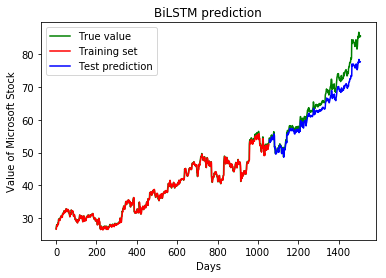

In [17]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='BiLSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       color=['g','r','b'], legend=['True value','Training set','Test prediction'])

### GRU
Finally, we are going to try with a [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRU), which is a simplified version of LSTM.

In [18]:
model = create_symbol(model_name='BiLSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

In [19]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/5
 - 4s - loss: 0.0204
Epoch 2/5
 - 3s - loss: 3.6655e-04
Epoch 3/5
 - 3s - loss: 3.6200e-04
Epoch 4/5
 - 3s - loss: 3.6521e-04
Epoch 5/5
 - 3s - loss: 3.6451e-04


In [20]:
pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

Test RMSE: 2.62


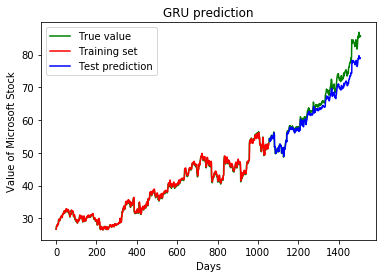

In [21]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='GRU prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       color=['g','r','b'], legend=['True value','Training set','Test prediction'])